# Fisheries competition and other CNN tricks

In this notebook we will classify species of fish. We will be using data from the [Kaggle competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter

In [2]:
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/competitit )<br/>
`kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -p /data2/yinterian/fisheries` <br/>

In [3]:
PATH = Path("/data2/yinterian/fisheries")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/fisheries/test_stg1.zip'),
 PosixPath('/data2/yinterian/fisheries/annotations'),
 PosixPath('/data2/yinterian/fisheries/bb_json_300.pkl'),
 PosixPath('/data2/yinterian/fisheries/annos.zip'),
 PosixPath('/data2/yinterian/fisheries/__MACOSX'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg2.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/mode_tmp.pth'),
 PosixPath('/data2/yinterian/fisheries/test_stg2.7z'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg1.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/train.zip'),
 PosixPath('/data2/yinterian/fisheries/train-300'),
 PosixPath('/data2/yinterian/fisheries/train'),
 PosixPath('/data2/yinterian/fisheries/models'),
 PosixPath('/data2/yinterian/fisheries/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/valid-300')]

In [4]:
list((PATH/"train").iterdir())

[PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/.DS_Store'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/YFT'),
 PosixPath('/data2/yinterian/fisheries/train/ALB')]

In [5]:
list((PATH/"train"/"ALB").iterdir())[:5]

[PosixPath('/data2/yinterian/fisheries/train/ALB/img_02140.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04320.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06727.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06086.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04377.jpg')]

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

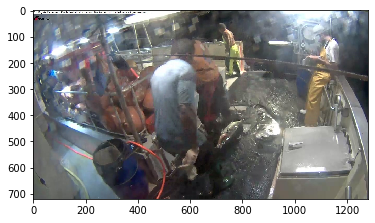

In [7]:
path = PATH/"train/ALB/img_02140.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(720, 1280, 3)

In [9]:
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [10]:
[(k[1]/k[0], counts[k]) for k in counts] 

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

## Resizing images

In [11]:
paths = sorted([x for x in list((PATH/"train").iterdir()) if x.is_dir()])
paths

[PosixPath('/data2/yinterian/fisheries/train/ALB'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/YFT')]

In [12]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[-3:]

[PosixPath('/data2/yinterian/fisheries/train/YFT/img_00783.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_02756.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_05644.jpg')]

In [13]:
# here is how you get the class
files[0].parts[-2]

'ALB'

In [14]:
labels = [p.parts[-1] for p in paths]
labels

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [15]:
{v:k for k, v in enumerate(labels)}

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [16]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

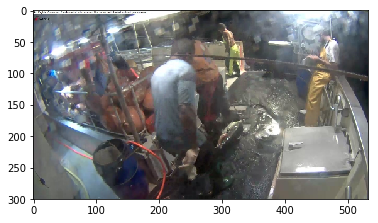

In [17]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)

In [18]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [19]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [20]:
#run just the first time
#resize_all_images(train_path, valid_path, PATH/"train")

In [21]:
# checking
for label in labels:
    all_files = len(list((PATH/"train"/label).iterdir()))
    train_files = len(list((train_path/label).iterdir()))
    valid_files = len(list((valid_path/label).iterdir()))
    print(label, all_files, train_files, valid_files)

ALB 1719 1377 342
BET 200 161 39
DOL 117 100 17
LAG 67 61 6
NoF 465 373 92
OTHER 299 233 66
SHARK 176 145 31
YFT 734 587 147


## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks. For this problem we cannot crop much because we may leave the fish out.

In [9]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

(300, 533, 3)


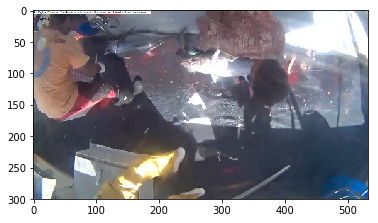

In [23]:
path = PATH/"train-300/ALB/img_03017.jpg"
im = read_image(path)
im2 = random_crop(im)
plt.imshow(im)
print(im.shape)

(284, 505, 3)

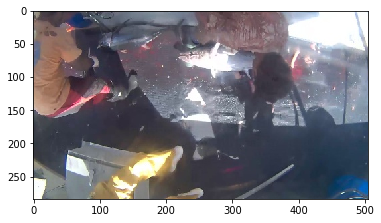

In [24]:
plt.imshow(im2)
im2.shape

### Random Rotation (-10, 10) 

1.1319706229201354


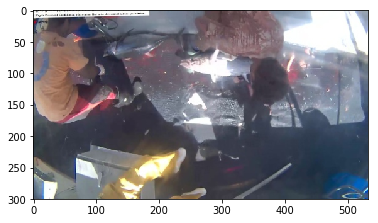

In [25]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

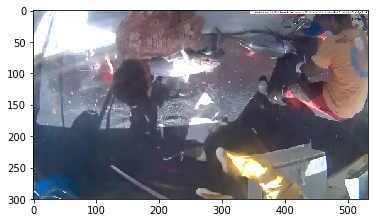

In [26]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [10]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [11]:
class FishDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in self.paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [12]:
train_ds = FishDataset(PATH, "train-300", transforms=True)
valid_ds = FishDataset(PATH, "valid-300")

In [13]:
len(train_ds), len(valid_ds)

(3037, 740)

In [14]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [15]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [16]:
x.shape,y

((3, 284, 505), 0)

In [17]:
x,y = next(iter(valid_dl))
x.shape

torch.Size([10, 3, 284, 505])

In [18]:
x, y = valid_ds[0]
x.shape

(3, 284, 505)

## Model

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet50(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(2048), nn.Linear(2048, 8))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [22]:
model = Net().cuda()

In [41]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([10, 3, 284, 505]), torch.Size([10]))

In [42]:
x = x.cuda().float()
y = y.cuda()

In [43]:
y

tensor([4, 0, 0, 0, 1, 1, 6, 4, 0, 0], device='cuda:0')

In [44]:
y_hat = model(x)
y_hat

tensor([[-0.2509, -0.3006, -0.1728, -0.0272,  0.3370, -0.2970,  0.1784,  0.2238],
        [-0.1037, -0.2514, -0.0535,  0.1656, -0.0511, -0.0064, -0.5279, -0.0772],
        [ 0.3279, -0.0591,  0.0885, -0.3997,  0.0414,  0.3702,  0.1753, -0.3765],
        [ 0.1108, -0.0470, -0.0242,  0.4766, -0.4047,  0.1361, -0.0972,  0.5806],
        [ 0.6904, -0.1629,  0.1537, -0.2496, -0.0948, -0.5814,  0.7271, -0.2502],
        [-0.2409,  0.0039,  0.3709, -0.3931,  0.0027,  0.1647, -0.3814, -0.3859],
        [-0.2588,  0.5476,  0.4252, -0.1299,  0.7028, -0.1154,  0.8739, -0.0376],
        [ 0.0748, -0.1040, -0.3934,  0.4835, -0.3431, -0.0755,  0.0471, -0.0672],
        [-0.4036,  0.6176, -0.5896, -0.0959,  0.0829,  0.1245, -0.3736, -0.0143],
        [ 0.0399, -0.0807,  0.2211,  0.1108, -0.3014,  0.3574, -0.4365,  0.6148]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [45]:
# hard prediction
_, pred = torch.max(y_hat, 1)
pred

tensor([4, 3, 5, 7, 6, 2, 6, 3, 1, 7], device='cuda:0')

In [46]:
y

tensor([4, 0, 0, 0, 1, 1, 6, 4, 0, 0], device='cuda:0')

In [47]:
pred.eq(y).sum()

tensor(2, device='cuda:0')

In [48]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.cross_entropy(y_hat, y).item()

2.0683090686798096

In [20]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [23]:
val_metrics(model, valid_dl)

(2.130261350322414, 0.021621621621621623)

## Learning rate finder

In [24]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [25]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.05, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [26]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [42]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

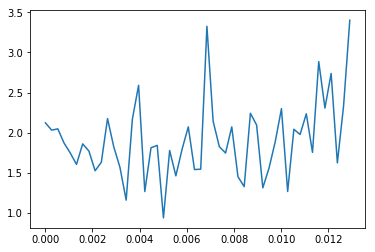

In [46]:
plt.plot(lrs[:50], losses[:50])
plt.show()

## One cycle rate training

In [19]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [20]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.9:
                path = "{0}/models/model_resnet50_loss_{1:.0f}.pth".format(PATH, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

## Training with one-cycle policy

In [26]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)

In [27]:
model = Net().cuda()

In [62]:
val_metrics(model, valid_dl)

val loss 2.090 and accuracy 0.107


In [28]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs=30)

train_loss 1.537 val_loss 0.990 val_acc 0.689
train_loss 0.631 val_loss 0.515 val_acc 0.861
train_loss 0.270 val_loss 0.572 val_acc 0.846
train_loss 0.185 val_loss 0.234 val_acc 0.924
/data2/yinterian/fisheries/models/model_resnet50_loss_92.pth
train_loss 0.199 val_loss 0.562 val_acc 0.877
train_loss 0.265 val_loss 0.929 val_acc 0.778
train_loss 0.292 val_loss 0.770 val_acc 0.826
train_loss 0.167 val_loss 0.270 val_acc 0.936
/data2/yinterian/fisheries/models/model_resnet50_loss_94.pth
train_loss 0.087 val_loss 0.407 val_acc 0.896
train_loss 0.161 val_loss 0.509 val_acc 0.855
train_loss 0.158 val_loss 1.121 val_acc 0.800
train_loss 0.134 val_loss 0.396 val_acc 0.901
train_loss 0.123 val_loss 0.302 val_acc 0.919
train_loss 0.066 val_loss 0.169 val_acc 0.957
/data2/yinterian/fisheries/models/model_resnet50_loss_96.pth
train_loss 0.059 val_loss 0.194 val_acc 0.950
train_loss 0.042 val_loss 0.175 val_acc 0.961
/data2/yinterian/fisheries/models/model_resnet50_loss_96.pth
train_loss 0.034 val

0.0006333231180457807

In [65]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs=30)

train_loss 1.668 val_loss 1.574 val_acc 0.458
train_loss 1.580 val_loss 1.508 val_acc 0.458
285 unfreezing 1
train_loss 1.489 val_loss 1.408 val_acc 0.480
train_loss 0.686 val_loss 0.421 val_acc 0.858
train_loss 0.228 val_loss 0.357 val_acc 0.882
570 unfreezing 0
train_loss 0.171 val_loss 0.497 val_acc 0.836
train_loss 0.181 val_loss 0.192 val_acc 0.946
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.132 val_loss 0.568 val_acc 0.816
train_loss 0.124 val_loss 0.350 val_acc 0.891
train_loss 0.121 val_loss 0.203 val_acc 0.950
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.065 val_loss 0.189 val_acc 0.949
train_loss 0.052 val_loss 0.303 val_acc 0.919
train_loss 0.058 val_loss 0.192 val_acc 0.950
train_loss 0.047 val_loss 0.183 val_acc 0.954
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.038 val_loss 0.168 val_acc 0.968
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.019 val_loss 0.180 

0.0005591723493161692

## Bounding boxes and multi-task learning
A kaggle user has created bounding boxes for each fish in the training set. [Here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902) is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box.

### Transfoms with bounding boxes

In [29]:
def make_bb_px(y, x_shape):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = x_shape 
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [30]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [31]:
def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [32]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = make_bb_px(bb, x.shape)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, to_bb(Y)

In [33]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

In [34]:
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [35]:
path = PATH/"train-300/DOL/img_01185.jpg"

In [36]:
path.parts[-1], path.parts[-2]

('img_01185.jpg', 'DOL')

In [37]:
import pickle
with open(PATH/'bb_json_300.pkl','rb') as f:
    bb_json_300 = pickle.load(f)

In [38]:
im = cv2.imread(str(path))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bb_json_300["img_01185.jpg"]

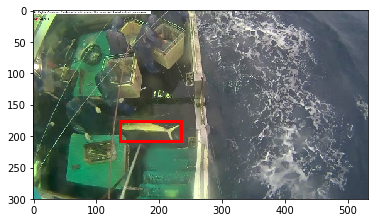

In [39]:
show_corner_bb(im, bb)

In [40]:
im_t, bb_t = transformsXY(path, bb, True)

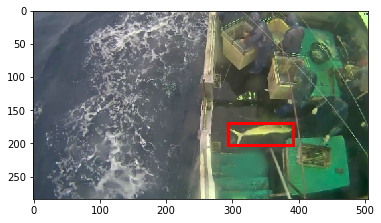

In [41]:
show_corner_bb(im_t, bb_t)

## New dataset
Here I have to start with the larger dataset because I need to transform x and y at the same time.

In [42]:
with open(PATH/'bb_json_300.pkl','rb') as f:
    bb_json_300 = pickle.load(f)

In [43]:
def get_files(path=PATH/"train-300"):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [44]:
train_files = get_files()
valid_files = get_files(PATH/"valid-300")

In [45]:
path=PATH/"train-300"
paths = [d for d in list(path.iterdir()) if d.is_dir()]
labels = [p.parts[-1] for p in paths]
labels

['DOL', 'NoF', 'LAG', 'SHARK', 'OTHER', 'BET', 'YFT', 'ALB']

In [46]:
{v:k for k,v in enumerate(labels)}

{'DOL': 0,
 'NoF': 1,
 'LAG': 2,
 'SHARK': 3,
 'OTHER': 4,
 'BET': 5,
 'YFT': 6,
 'ALB': 7}

In [47]:
class FishDataset2(Dataset):
    def __init__(self, files, bb_json=bb_json_300, transforms=False, labels=labels):
        self.transforms = transforms
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.bb_json = bb_json
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        bb_exist = 0
        if name in self.bb_json:
            bb = self.bb_json[name]
            bb_exist = 1
        else:
            bb = np.zeros(4)
        x, y_bb = transformsXY(path, bb, self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb, bb_exist

In [48]:
train_ds2 = FishDataset2(train_files, transforms=True)
valid_ds2 = FishDataset2(valid_files)

In [49]:
x, y_class, y_bb, bb_exist = train_ds2[20]
x.shape, y_class, y_bb, bb_exist

((3, 284, 505), 0, array([162., 154., 217., 251.], dtype=float32), 1)

In [50]:
batch_size = 10
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

## Model

In [51]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier1 = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 8))
        self.classifier2 = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x1 = self.classifier1(x)
        x2 = self.classifier2(x)
        return x1, x2

In [52]:
net = Net2().cuda()

In [54]:
x, y1, y2, z = next(iter(train_dl2))

In [55]:
y1 = y1.cuda()
y2 = y2.cuda()
out_class, out_bb = net(x.float().cuda())

In [56]:
y1.long()

tensor([7, 3, 4, 7, 1, 4, 6, 7, 1, 4], device='cuda:0')

In [57]:
F.cross_entropy(out_class, y1.long())

tensor(2.0303, device='cuda:0', grad_fn=<NllLossBackward>)

In [58]:
F.l1_loss(out_bb, y2.float()).item()

89.40596008300781

In [59]:
F.l1_loss(out_bb, y2.float(), reduction="sum").item()

3576.23828125

In [60]:
# loss per observation
F.l1_loss(out_bb, y2.float(), reduction="none")

tensor([[4.3497e+01, 1.8833e+02, 1.3451e+02, 3.5671e+02],
        [1.4779e+02, 2.7579e+02, 2.0154e+02, 3.1029e+02],
        [1.8903e-01, 2.7411e-01, 6.3985e-01, 4.0657e-02],
        [6.1867e+01, 2.3922e+02, 1.1703e+02, 3.0818e+02],
        [3.6449e-01, 3.7726e-02, 1.7737e-01, 2.0948e-01],
        [3.0508e-01, 5.0177e-02, 3.1671e-01, 4.5756e-01],
        [4.5263e+00, 8.8704e+01, 6.7556e+01, 2.2071e+02],
        [1.2717e+02, 2.3106e+02, 1.5771e+02, 2.8968e+02],
        [1.4051e-01, 1.6098e-01, 3.6239e-01, 6.5513e-02],
        [2.2448e-01, 5.9818e-02, 3.5875e-02, 2.6730e-01]], device='cuda:0',
       grad_fn=<L1LossBackward>)

In [61]:
# here is an issue not all images have a bounding box
z = z.cuda().float()
z

tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 0.], device='cuda:0')

In [62]:
z.sum()

tensor(5., device='cuda:0')

In [63]:
F.l1_loss(out_bb, y2.float(), reduction="none").sum(1).shape

torch.Size([10])

In [64]:
z*F.l1_loss(out_bb, y2.float(), reduction="none").sum(1)

tensor([723.0436, 935.4052,   0.0000, 726.2980,   0.0000,   0.0000, 381.4921,
        805.6205,   0.0000,   0.0000], device='cuda:0', grad_fn=<MulBackward0>)

In [65]:
l = z*F.l1_loss(out_bb, y2.float(), reduction="none").sum(1)
l.sum()/z.sum()

tensor(714.3718, device='cuda:0', grad_fn=<DivBackward0>)

In [66]:
def val_metrics2(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb, z in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        z = z.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = z*F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [67]:
val_metrics2(net, valid_dl2)

(2.774491598799422, 0.12027027027027028)

## Training v2

In [69]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier1.parameters(), 'lr': lr0},
              {'params': model.classifier2.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [75]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.01, epochs=10, C=1000):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, z in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/9, lr/3, lr, lr])
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            z = z.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = z*F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics2(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.9:
                path = "{0}/models/model_resnet34_loss_{1:.0f}.pth".format(PATH, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [76]:
net = Net2().cuda()

In [77]:
batch_size = 32
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

In [78]:
val_metrics2(net, valid_dl2)

(2.52079002535021, 0.3689189189189189)

In [79]:
train_triangular_policy2(net, train_dl2, valid_dl2, max_lr=0.001, epochs=30)

train_loss 2.290 val_loss 1.715 val_acc 0.716
train_loss 1.453 val_loss 1.075 val_acc 0.889
train_loss 0.987 val_loss 0.900 val_acc 0.927
/data2/yinterian/fisheries/models/model_resnet34_loss_93.pth
train_loss 0.833 val_loss 0.882 val_acc 0.916
train_loss 0.769 val_loss 1.059 val_acc 0.845
train_loss 0.712 val_loss 1.153 val_acc 0.811
train_loss 0.451 val_loss 0.420 val_acc 0.938
/data2/yinterian/fisheries/models/model_resnet34_loss_94.pth
train_loss 0.342 val_loss 0.439 val_acc 0.928
train_loss 0.345 val_loss 0.366 val_acc 0.946
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.268 val_loss 0.333 val_acc 0.947
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.246 val_loss 0.313 val_acc 0.950
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.211 val_loss 0.303 val_acc 0.965
/data2/yinterian/fisheries/models/model_resnet34_loss_96.pth
train_loss 0.192 val_loss 0.307 val_acc 0.947
train_loss 0.180 val_loss 0.249 val_

0.06014227443201431

## Making predictions

In [80]:
net = Net2().cuda()
model_path = PATH/"models/model_resnet34_loss_98.pth"
load_model(net, model_path)
val_metrics2(net, valid_dl2)

(0.15786465875603056, 0.981081081081081)

In [81]:
# making predictions
path = PATH/"train-300/ALB/img_01160.jpg"
test_ds = FishDataset2([path])
x, y_class, y_bb, z = test_ds[0]

In [82]:
x.shape

(3, 284, 505)

In [83]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 505])

In [84]:
out_class, out_bb = net(xx.cuda())
out_class, out_bb

(tensor([[-3.3567, -3.4817, -0.4071, -4.1030, -0.4385, -3.0589, -2.7336, 10.5296]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[177.4126, 256.3095, 238.3611, 309.5790]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [85]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([10.5296], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([7], device='cuda:0'))

In [86]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
bb_hat

array([[177, 256, 238, 309]])

In [87]:
bb = bb_json_300["img_01160.jpg"]
bb

array([176., 273., 260., 312.], dtype=float32)

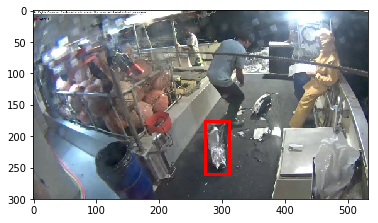

In [88]:
im = cv2.imread(str(path))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, bb)

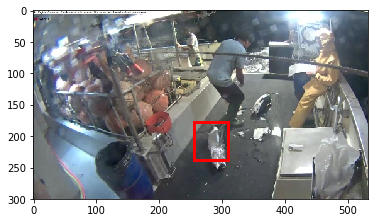

In [89]:
#here is the predicted
show_corner_bb(im, bb_hat[0])

# References
This notebook was originaly based on the Keras implementation from [fast.ai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb).

In [90]:
model

Net(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_